## Postprocessing outputs from 9 dimensional problem to receive final suggestions for experiments

This Notebook performs the postprocessing for the 9 dimensional problem.

As components we have the polymer PA56, phytic acid, the amino-based components (MEL, THAM, CS, BN) and the metallic-based components (ZnBO, CABO, HNT).

Here loaded from Outputs_orig folder corresponding to the results shown in the paper, but can also run Sampling_4components notebook and then load results from Outputs folder here


It contains the following steps:
1. Import all output files and format as data frames
2. LHS calculation and export to file, discrepancies and variance**
3. LHSMDU calculation and export to file, discrepancies and variance**
4. Import and format data set
5. Reduce to 2 dimensions and plot
6. Calculate other discrepancies and variance to check space filling properties/ uniformity
7. Distribution plots
8. Discrepancy for LHS and LHSMDU without constraints


written by Christina Schenk

last updated on 05/07/2024

tested on Christina's M1 Mac

#### Import Python Packages

In [1]:
import pandas as pd
import os
from pathlib import Path  
import csv
from scipy.stats import qmc
import lhsmdu
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('..')
from src.plot import *
from src.conditionedSampling import *


### **1. Import all output files and format as data frames**

In [2]:
filename_lhs_amino = "Outputs_orig/LHS_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_amino-based.csv"
filename_lhsmdu_amino = "Outputs_orig/LHSMDU_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_amino-based.csv"
filename_lhs_metallic = "Outputs_orig/LHS_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_metallic-based.csv"
filename_lhsmdu_metallic = "Outputs_orig/LHSMDU_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_metallic-based.csv"
filename_lhs = "Outputs_orig/LHS_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_improve.csv"
filename_lhsmdu = "Outputs_orig/LHSMDU_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_improve.csv"

df_lhs_amino = pd.read_csv(filename_lhs_amino)
df_lhs_amino = df_lhs_amino.loc[:, ~df_lhs_amino.columns.str.contains('^Unnamed')]
df_lhsmdu_amino = pd.read_csv(filename_lhsmdu_amino)
df_lhsmdu_amino = df_lhsmdu_amino.loc[:, ~df_lhsmdu_amino.columns.str.contains('^Unnamed')]
df_lhs_metallic = pd.read_csv(filename_lhs_metallic)
df_lhs_metallic = df_lhs_metallic.loc[:, ~df_lhs_metallic.columns.str.contains('^Unnamed')]
df_lhsmdu_metallic = pd.read_csv(filename_lhsmdu_metallic)
df_lhsmdu_metallic = df_lhsmdu_metallic.loc[:, ~df_lhsmdu_metallic.columns.str.contains('^Unnamed')]
df_lhs = pd.read_csv(filename_lhs)
df_lhs = df_lhs.loc[:, ~df_lhs.columns.str.contains('^Unnamed')]
df_lhsmdu= pd.read_csv(filename_lhsmdu)
df_lhsmdu = df_lhsmdu.loc[:, ~df_lhsmdu.columns.str.contains('^Unnamed')]


In [3]:
df_lhs.columns = ["PA56", "PhA", "amino-based", "metallic-based"]
df_lhsmdu.columns = ["PA56", "PhA", "amino-based", "metallic-based"]
df_lhs_amino.columns = ["MEL", "THAM", "CS", "BN"]
df_lhsmdu_amino.columns = ["MEL", "THAM", "CS", "BN"]
df_lhs_metallic.columns = ["ZnBO", "CABO", "HNT"]
df_lhsmdu_metallic.columns = ["ZnBO", "CABO", "HNT"]

### **2. LHS calculation and export to file, discrepancies and variance**

In [4]:

column_names = [df_lhs.columns.values.tolist(), df_lhs_amino.columns.values.tolist(), df_lhs_metallic.columns.values.tolist()]
df_all = pd.concat([df_lhs, df_lhs_amino, df_lhs_metallic], axis=1, join="inner")


In [5]:
df_all

,PA56,PhA,amino-based,metallic-based,MEL,THAM,CS,BN,ZnBO,CABO,HNT
0,0.902,0.024,0.021,0.054,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0
1,0.859,0.044,0.041,0.057,0.000000,0.000000,1.000000,0.0,1.0,0.0,0.0
2,0.975,0.010,0.004,0.011,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0
3,0.906,0.027,0.038,0.029,0.368535,0.000000,0.631465,0.0,0.0,1.0,0.0
4,0.933,0.019,0.005,0.044,0.732822,0.000000,0.267178,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
85,0.819,0.025,0.045,0.111,0.509312,0.490688,0.000000,0.0,1.0,0.0,0.0
86,0.921,0.044,0.006,0.030,0.463863,0.536137,0.000000,0.0,0.0,1.0,0.0
87,0.851,0.014,0.002,0.133,1.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
88,0.836,0.004,0.032,0.128,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0


In [6]:
df_all["MEL"] = df_all["MEL"]*df_all["amino-based"]
df_all["MEL"] = df_all["MEL"].round(3)
df_all["THAM"] = df_all["THAM"]*df_all["amino-based"]
df_all["THAM"] = df_all["THAM"].round(3)
df_all["CS"] = df_all["CS"]*df_all["amino-based"]
df_all["CS"] = df_all["CS"].round(3)
df_all["BN"] = df_all["BN"]*df_all["amino-based"]
df_all["BN"] = df_all["BN"].round(3)

In [7]:
df_all["ZnBO"] = df_all["ZnBO"]*df_all["metallic-based"]
df_all["ZnBO"] = df_all["ZnBO"].round(3)
df_all["CABO"] = df_all["CABO"]*df_all["metallic-based"]
df_all["CABO"] = df_all["CABO"].round(3)
df_all["HNT"] = df_all["HNT"]*df_all["metallic-based"]
df_all["HNT"] = df_all["HNT"].round(3)

In [8]:
df_all = df_all.drop(['amino-based', 'metallic-based'], axis=1)

In [9]:
df_perc = df_all*100

#### Make sure that add up to 1, if not randomly take one where add error

In [10]:
for i in range(len(df_all)):
    if abs(df_all.iloc[i,:].sum()-1)>1e-4:
        ind_list = np.where(df_all.iloc[i,:]!=0)[0]
        ind = np.random.choice(ind_list)
        df_all.iloc[i,ind] = df_all.iloc[i,ind] - (df_all.iloc[i,:].sum()-1)
        #print(ind)
        #print(i, df_all.loc[i,:].sum())

In [11]:
df_perc

,PA56,PhA,MEL,THAM,CS,BN,ZnBO,CABO,HNT
0,90.2,2.4,0.0,0.0,2.1,0.0,0.0,5.4,0.0
1,85.9,4.4,0.0,0.0,4.1,0.0,5.7,0.0,0.0
2,97.5,1.0,0.0,0.0,0.0,0.4,1.1,0.0,0.0
3,90.6,2.7,1.4,0.0,2.4,0.0,0.0,2.9,0.0
4,93.3,1.9,0.4,0.0,0.1,0.0,0.0,4.4,0.0
...,...,...,...,...,...,...,...,...,...
85,81.9,2.5,2.3,2.2,0.0,0.0,11.1,0.0,0.0
86,92.1,4.4,0.3,0.3,0.0,0.0,0.0,3.0,0.0
87,85.1,1.4,0.2,0.0,0.0,0.0,0.0,13.3,0.0
88,83.6,0.4,0.0,0.0,3.2,0.0,0.0,12.8,0.0


#### Define bounds, space and calculate discrepancies and variance for comparison

In [12]:
l_bounds = [0.8, 0, 0, 0, 0, 0, 0 , 0 , 0]
u_bounds = [1., 0.05, 0.1, 0.1 , 0.1, 0.1, 0.14, 0.14, 0.14]
space = qmc.scale(df_all, l_bounds, u_bounds, reverse=True)

In [13]:
qmc.discrepancy(space)

5.546944977920964

In [14]:
qmc.discrepancy(space, method='WD')

7.070611990292666

In [15]:
np.linalg.norm(space.var())

np.float64(0.07499052436941854)

In [16]:
filepath = Path('Outputs/postprocessed_outputs_all_9dim.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_all.to_csv(filepath) 

### **3. LHSMDU calculation and export to file, discrepancies and variance**

In [17]:

column_names = [df_lhsmdu.columns.values.tolist(), df_lhsmdu_amino.columns.values.tolist(), df_lhsmdu_metallic.columns.values.tolist()]
df_all_lhsmdu = pd.concat([df_lhsmdu, df_lhsmdu_amino, df_lhsmdu_metallic], axis=1, join="inner")


In [18]:
df_all_lhsmdu

,PA56,PhA,amino-based,metallic-based,MEL,THAM,CS,BN,ZnBO,CABO,HNT
0,0.840,0.045,0.039,0.076,0.754504,0.245496,0.000000,0.0,0.0,0.0,1.0
1,0.882,0.044,0.021,0.053,0.000000,0.000000,1.000000,0.0,0.0,0.0,1.0
2,0.909,0.006,0.056,0.030,0.504332,0.000000,0.495668,0.0,0.0,0.0,1.0
3,0.892,0.030,0.023,0.054,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0
4,0.918,0.025,0.039,0.018,0.000000,1.000000,0.000000,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
85,0.928,0.044,0.010,0.018,1.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
86,0.824,0.030,0.095,0.051,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0
87,0.926,0.043,0.000,0.031,0.400443,0.599557,0.000000,0.0,0.0,1.0,0.0
88,0.855,0.003,0.007,0.135,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0


In [19]:
df_all_lhsmdu["MEL"] = df_all_lhsmdu["MEL"]*df_all_lhsmdu["amino-based"]
df_all_lhsmdu["MEL"] = df_all_lhsmdu["MEL"].round(3)
df_all_lhsmdu["THAM"] = df_all_lhsmdu["THAM"]*df_all_lhsmdu["amino-based"]
df_all_lhsmdu["THAM"] = df_all_lhsmdu["THAM"].round(3)
df_all_lhsmdu["CS"] = df_all_lhsmdu["CS"]*df_all_lhsmdu["amino-based"]
df_all_lhsmdu["CS"] = df_all_lhsmdu["CS"].round(3)
df_all_lhsmdu["BN"] = df_all_lhsmdu["BN"]*df_all_lhsmdu["amino-based"]
df_all_lhsmdu["BN"] = df_all_lhsmdu["BN"].round(3)

In [20]:
df_all_lhsmdu["ZnBO"] = df_all_lhsmdu["ZnBO"]*df_all_lhsmdu["metallic-based"]
df_all_lhsmdu["ZnBO"] = df_all_lhsmdu["ZnBO"].round(3)
df_all_lhsmdu["CABO"] = df_all_lhsmdu["CABO"]*df_all_lhsmdu["metallic-based"]
df_all_lhsmdu["CABO"] = df_all_lhsmdu["CABO"].round(3)
df_all_lhsmdu["HNT"] = df_all_lhsmdu["HNT"]*df_all_lhsmdu["metallic-based"]
df_all_lhsmdu["HNT"] = df_all_lhsmdu["HNT"].round(3)

In [21]:
df_all_lhsmdu = df_all_lhsmdu.drop(['amino-based', 'metallic-based'], axis=1)

In [22]:
df_perc_lhsmdu = df_all_lhsmdu*100

In [23]:
space_lhsmdu = qmc.scale(df_all_lhsmdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space_lhsmdu)

5.360806428606857

In [24]:
qmc.discrepancy(space_lhsmdu, method='WD')

6.594884709146623

In [25]:
np.linalg.norm(space_lhsmdu.var())

np.float64(0.07110041042539557)

#### Make sure that add up to 1, if not randomly take one where add error

In [26]:
for i in range(len(df_all_lhsmdu)):
    if abs(df_all_lhsmdu.loc[i,:].sum()-1)>1e-4:
        ind_list = np.where(df_all_lhsmdu.loc[i,:]!=0)[0]
        ind = np.random.choice(ind_list)
        df_all_lhsmdu.iloc[i,ind] = df_all_lhsmdu.iloc[i,ind] - (df_all_lhsmdu.loc[i,:].sum()-1)
        #print(ind)
        #print(i, df_perc_lhsmdu.loc[i,:].sum())

In [27]:
filepath = Path('Outputs/postprocessed_outputs_lhsmdu_all_9dim.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_all_lhsmdu.to_csv(filepath) 

### **4. Import and format data set**

In [28]:
filename = './data/Bank_Data-2808_mod_corrected.csv'#Bank_Data_mod_clean.csv'
df = pd.read_csv(filename, sep=';', decimal=",")
df = df.div(100.)
data_array = np.zeros((len(df),8))
data_array = np.column_stack((df['PA-56'].to_numpy(), df['PhA'], df['Mel'], df['THAM'], df['CS'], df['BN'], df['ZnBO'], df['CaBO'], df['HNT']))

#### Scaling of data

In [29]:
scaler = StandardScaler().fit(data_array)
data_scaled = scaler.transform(data_array)
scaler2 = StandardScaler().fit(df_all)
all_val_samples_scaled = scaler2.transform(df_all)
scaler3 = StandardScaler().fit(df_all_lhsmdu)
all_val_samples_mdu_scaled = scaler3.transform(df_all_lhsmdu)

### **5. Reduce to 2 dimensions and plot**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


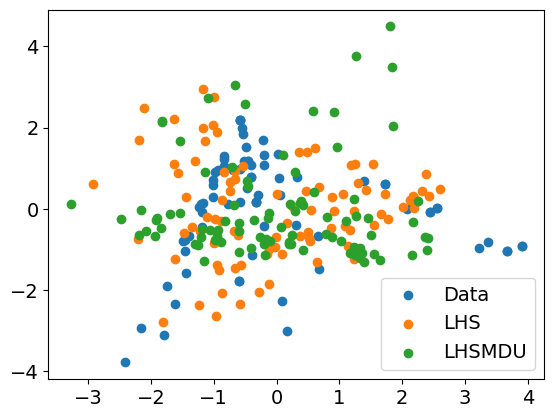

In [30]:
pca = PCA(n_components=2)
Xt1_pca = pca.fit_transform(data_scaled)
Xt2_pca = pca.fit_transform(all_val_samples_scaled)
Xt3_pca = pca.fit_transform(all_val_samples_mdu_scaled)
    
plot_dimred_2dims_both_methods(Xt1_pca, Xt2_pca, Xt3_pca, filename_eps='Figures_9dim/plot_scaled_90pts.eps')

In [31]:
tol = 5e-1
tol2 = 5e-1
des_n_samp = 15

tol_samples, tol_samples_LHSMDU, tol_samples_unscaled, tol_samples_LHSMDU_unscaled = select_samples_diff_from_data(exp_data=data_array, samples_LHS=df_all.to_numpy(), samples_LHSMDU=df_all_lhsmdu.to_numpy(), des_n_samp = des_n_samp, tol = tol, tol2 = tol2)


In [32]:
df_15_samps_scaled = pd.DataFrame(tol_samples,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
df_15_samps = pd.DataFrame(tol_samples_unscaled,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])

#### Check if add up to 100%

In [33]:
df_perc = df_15_samps*100
for i in range(len(df_perc)):
    if abs(sum(df_perc.iloc[i,:])-100)>1e-2:
        print(sum(df_perc.iloc[i,:]))

In [34]:
df_perc

,PA-56,PhA,Mel,THAM,CS,BN,ZnBO,CaBO,HNT
0,82.1,4.0,3.4,4.2,0.0,0.0,0.0,0.0,6.3
1,82.4,1.6,6.5,2.8,0.0,0.0,0.0,6.7,0.0
2,81.9,3.2,4.0,0.0,1.7,0.0,9.2,0.0,0.0
3,80.3,4.2,0.0,0.0,0.0,6.6,0.0,8.9,0.0
4,81.4,1.7,3.0,0.0,1.5,0.0,0.0,12.4,0.0
5,81.7,1.8,0.0,0.0,3.8,0.0,0.0,12.7,0.0
6,83.6,0.4,0.0,0.0,3.2,0.0,0.0,12.8,0.0
7,84.1,4.7,0.0,0.0,9.4,0.0,0.0,1.8,0.0
8,80.1,4.1,0.0,0.0,8.5,0.0,0.0,7.3,0.0
9,80.1,2.2,0.0,0.0,0.0,6.8,0.0,10.9,0.0


In [35]:
filepath = Path('Outputs/postprocessed_outputs_15lhs_9dim.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_perc.to_csv(filepath, float_format='%.1f') 

### **6. Calculate other discrepancies and variance to check space filling properties/uniformity**

In [36]:
space = qmc.scale(df_15_samps, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

4.892160115953185

In [37]:
qmc.discrepancy(space, method='WD')

7.1872165093268

In [38]:
np.linalg.norm(space.var())

np.float64(0.08661404372777919)

In [39]:
df_data = df[['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT']].copy()
df_data = df_data
df_with_data = pd.concat([df_15_samps, df_data], ignore_index=True, axis=0)

In [40]:
df_with_data

,PA-56,PhA,Mel,THAM,CS,BN,ZnBO,CaBO,HNT
0,0.821,0.040,0.034,0.042,0.000,0.000,0.000,0.000,0.063
1,0.824,0.016,0.065,0.028,0.000,0.000,0.000,0.067,0.000
2,0.819,0.032,0.040,0.000,0.017,0.000,0.092,0.000,0.000
3,0.803,0.042,0.000,0.000,0.000,0.066,0.000,0.089,0.000
4,0.814,0.017,0.030,0.000,0.015,0.000,0.000,0.124,0.000
...,...,...,...,...,...,...,...,...,...
85,0.900,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.050
86,0.970,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.020
87,0.950,0.000,0.017,0.000,0.000,0.000,0.000,0.000,0.033
88,0.930,0.000,0.023,0.000,0.000,0.000,0.000,0.000,0.047


In [41]:
space = qmc.scale(df_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

8.988937730355344

In [42]:
qmc.discrepancy(space, method='WD')

9.848937884716944

In [43]:
np.linalg.norm(space.var())

np.float64(0.07141894876652076)

In [44]:
df_15_samps_lhsmdu = pd.DataFrame(tol_samples_LHSMDU_unscaled,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
df_15_samps_lhsmdu_scaled = pd.DataFrame(tol_samples_LHSMDU,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])

In [45]:
space = qmc.scale(df_15_samps_lhsmdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

5.126540939266676

In [46]:
qmc.discrepancy(space, method='WD')

8.10819823936559

In [47]:
np.linalg.norm(space.var())

np.float64(0.07861363690826122)

#### Check if add up to 100%

In [48]:
df_perc_lhsmdu = df_15_samps_lhsmdu*100
for i in range(len(df_perc_lhsmdu)):
    if abs(sum(df_perc_lhsmdu.iloc[i,:])-100)>1e-2:
        print(sum(df_perc_lhsmdu.iloc[i,:]))

In [49]:
df_perc_lhsmdu

,PA-56,PhA,Mel,THAM,CS,BN,ZnBO,CaBO,HNT
0,84.1,4.3,5.0,0.0,0.0,0.0,6.6,0.0,0.0
1,85.5,0.3,0.0,0.0,0.7,0.0,0.0,13.5,0.0
2,85.6,1.9,3.4,0.0,1.5,0.0,7.6,0.0,0.0
3,80.8,1.7,0.0,3.5,3.1,0.0,10.9,0.0,0.0
4,80.3,0.7,0.0,0.0,0.0,9.9,0.0,9.1,0.0
5,84.6,4.0,4.5,0.0,4.1,0.0,2.8,0.0,0.0
6,86.4,1.2,0.0,0.0,3.4,0.0,9.0,0.0,0.0
7,83.2,1.7,0.0,0.0,7.8,0.0,0.0,7.3,0.0
8,81.7,4.1,5.5,0.0,0.0,0.0,0.0,8.7,0.0
9,84.9,0.2,0.0,9.3,0.0,0.0,5.6,0.0,0.0


In [50]:
filepath = Path('Outputs/postprocessed_outputs_15lhsmdu_9dim.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_perc_lhsmdu.to_csv(filepath, float_format='%.1f') 

In [51]:
space = qmc.scale(df_15_samps_lhsmdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

5.126540939266676

In [52]:
qmc.discrepancy(space, method='WD')

8.10819823936559

In [53]:
np.linalg.norm(space.var())

np.float64(0.07861363690826122)

In [54]:
df_lhsmdu_with_data = pd.concat([df_15_samps_lhsmdu, df_data], ignore_index=True, axis=0)

In [55]:
space = qmc.scale(df_lhsmdu_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

9.08468179539749

In [56]:
qmc.discrepancy(space, method='WD')

9.87515506486541

In [57]:
np.linalg.norm(space.var())

np.float64(0.06992868393941938)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


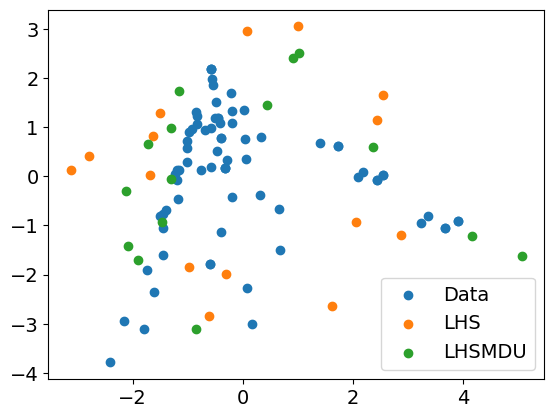

In [58]:
pca = PCA(n_components=2)
Xt1_pca = pca.fit_transform(data_scaled)
Xt2_pca = pca.fit_transform(df_15_samps_scaled)
Xt3_pca = pca.fit_transform(df_15_samps_lhsmdu_scaled)
    
plot_dimred_2dims_both_methods(Xt1_pca, Xt2_pca, Xt3_pca, filename_eps='Figures_9dim/plot_scaled_15pts.eps')

### **7. Distribution plots**

In [59]:
df_perc_lhsmdu = df_15_samps_lhsmdu*100
for i in range(len(df_perc_lhsmdu)):
    if abs(sum(df_perc_lhsmdu.iloc[i,:])-100)>1e-2:
        print(sum(df_perc_lhsmdu.iloc[i,:]))

In [60]:
df_perc_lhsmdu

,PA-56,PhA,Mel,THAM,CS,BN,ZnBO,CaBO,HNT
0,84.1,4.3,5.0,0.0,0.0,0.0,6.6,0.0,0.0
1,85.5,0.3,0.0,0.0,0.7,0.0,0.0,13.5,0.0
2,85.6,1.9,3.4,0.0,1.5,0.0,7.6,0.0,0.0
3,80.8,1.7,0.0,3.5,3.1,0.0,10.9,0.0,0.0
4,80.3,0.7,0.0,0.0,0.0,9.9,0.0,9.1,0.0
5,84.6,4.0,4.5,0.0,4.1,0.0,2.8,0.0,0.0
6,86.4,1.2,0.0,0.0,3.4,0.0,9.0,0.0,0.0
7,83.2,1.7,0.0,0.0,7.8,0.0,0.0,7.3,0.0
8,81.7,4.1,5.5,0.0,0.0,0.0,0.0,8.7,0.0
9,84.9,0.2,0.0,9.3,0.0,0.0,5.6,0.0,0.0


In [61]:
space = qmc.scale(df_15_samps_lhsmdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

5.126540939266676

In [62]:
qmc.discrepancy(space, method='WD')

8.10819823936559

In [63]:
np.linalg.norm(space.var())

np.float64(0.07861363690826122)

In [64]:
df_lhsmdu_with_data = pd.concat([df_15_samps_lhsmdu, df_data], ignore_index=True, axis=0)

In [65]:
space = qmc.scale(df_lhsmdu_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

9.08468179539749

In [66]:
qmc.discrepancy(space, method='WD')

9.87515506486541

In [67]:
np.linalg.norm(space.var())

np.float64(0.06992868393941938)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


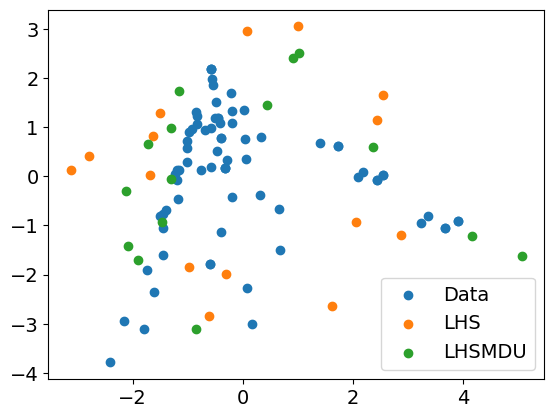

In [68]:
pca = PCA(n_components=2)
Xt1_pca = pca.fit_transform(data_scaled)
Xt2_pca = pca.fit_transform(df_15_samps_scaled)
Xt3_pca = pca.fit_transform(df_15_samps_lhsmdu_scaled)
    
plot_dimred_2dims_both_methods(Xt1_pca, Xt2_pca, Xt3_pca, filename_eps="Figures_9dim/plot_scaled_15pts.eps")

#### Distribution subplots of unscaled data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


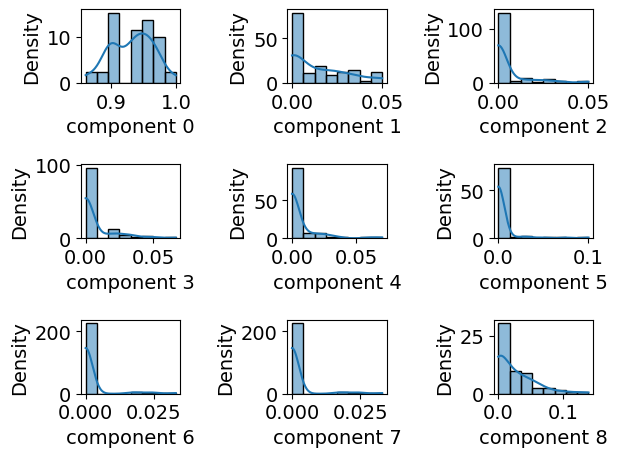

In [69]:
box_kdeplot_samples(data_array, filename_eps='Figures_9dim/dist_unscaled_expdata.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


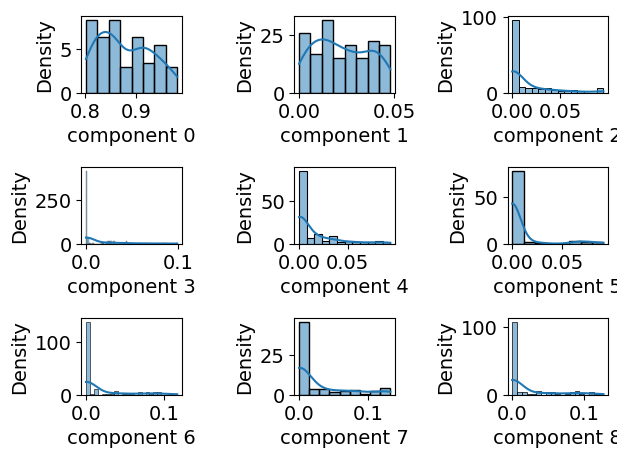

In [70]:
box_kdeplot_samples(df_all.to_numpy(), filename_eps='Figures_9dim/dist_unscaled_90ptsLHS.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


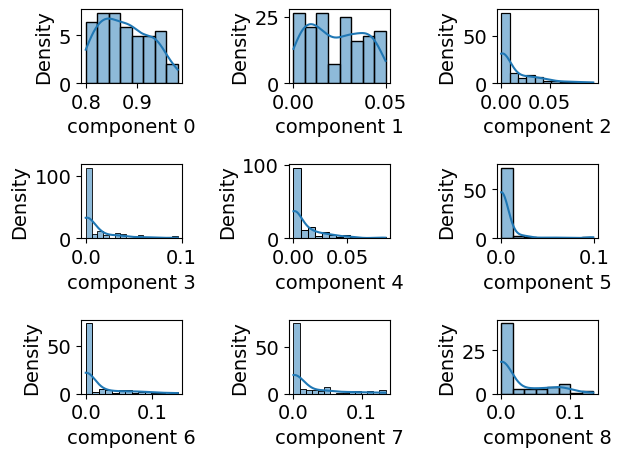

In [71]:
box_kdeplot_samples(df_all_lhsmdu.to_numpy(), filename_eps='Figures_9dim/dist_unscaled_90ptsLHSMDU.eps')

#### Distribution subplots of unscaled reduced data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


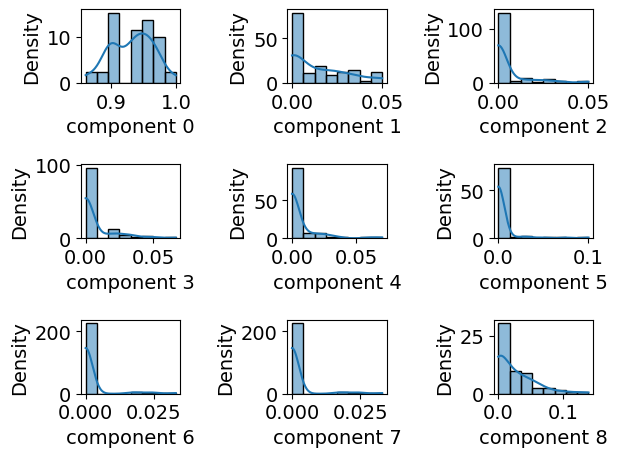

In [72]:
box_kdeplot_samples(data_array, filename_eps='Figures_9dim/dist_unscaled_expdata.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


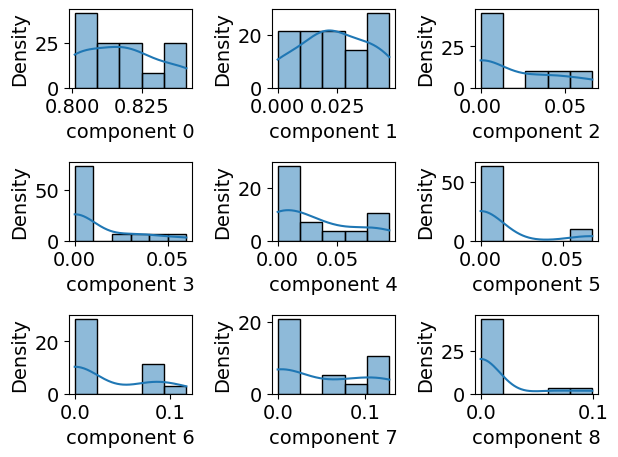

In [73]:
box_kdeplot_samples(tol_samples_unscaled, filename_eps='Figures_9dim/dist_unscaled_15ptsLHS.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


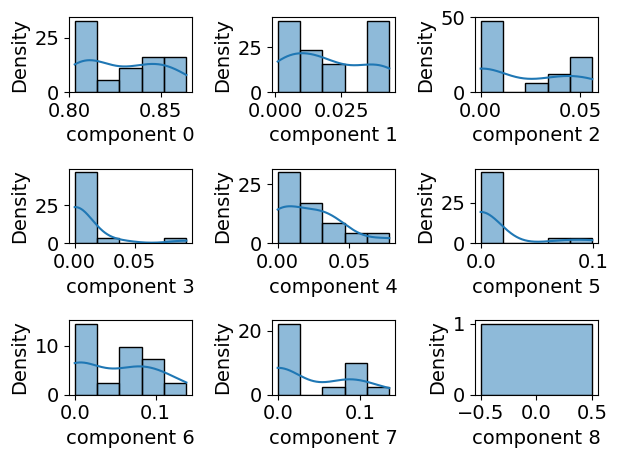

In [74]:
box_kdeplot_samples(tol_samples_LHSMDU_unscaled, filename_eps='Figures_9dim/dist_unscaled_15ptsLHSMDU.eps')

### **8.Discrepancy for LHS and LHSMDU without constraints**

#### LHS

In [75]:
n_samp=90
dim = 9
seed = 1234

sampler_new = qmc.LatinHypercube(d=dim, seed=seed)
sample = sampler_new.random(n=n_samp)
sample = qmc.scale(sample, l_bounds, u_bounds)

In [76]:
np.linalg.norm(sample.var())

np.float64(0.0720915097498305)

In [77]:
qmc.discrepancy(sample)

19.944665550086615

In [78]:
qmc.discrepancy(sample, method="WD")

17.386381914924844

#### LHSMDU

In [79]:
seed = 1234
lhsmdu.setRandomSeed(seed)
sample_LHSMDU = lhsmdu.sample(9, n_samp).transpose()
sample_LHSMDU = qmc.scale(sample_LHSMDU, l_bounds, u_bounds)

In [80]:
np.linalg.norm(sample_LHSMDU.var())

np.float64(0.07211860057372815)

In [81]:
qmc.discrepancy(sample_LHSMDU)

19.956508834860465

In [82]:
qmc.discrepancy(sample_LHSMDU, method="WD")

17.38992615424273

#### Selected LHS and LHSMDU Samples by checking distance from data

In [83]:
tol = 5e-1#8e-1#8e-1
tol2 = 5e-1#1e-5
des_n_samp = 15

tol_samples_comp, tol_samples_LHSMDU_comp, tol_samples_unscaled_comp, tol_samples_LHSMDU_unscaled_comp = select_samples_diff_from_data(exp_data=data_array, samples_LHS=sample, samples_LHSMDU=sample_LHSMDU, des_n_samp = des_n_samp, tol = tol, tol2 = tol2)


In [84]:
df_15_samps_scaled_comp = pd.DataFrame(tol_samples_comp,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
df_15_samps_comp = pd.DataFrame(tol_samples_unscaled_comp,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])

In [85]:
df_15_samps_comp

,PA-56,PhA,Mel,THAM,CS,BN,ZnBO,CaBO,HNT
0,0.989,0.041,0.035,0.090,0.095,0.050,0.140,0.113,0.057
1,0.878,0.035,0.023,0.090,0.056,0.002,0.074,0.119,0.125
2,0.955,0.049,0.076,0.005,0.075,0.084,0.031,0.056,0.116
3,0.878,0.030,0.089,0.010,0.092,0.047,0.108,0.126,0.129
4,0.906,0.046,0.080,0.017,0.033,0.054,0.134,0.136,0.030
5,0.830,0.041,0.012,0.028,0.099,0.087,0.137,0.011,0.134
6,0.826,0.012,0.042,0.096,0.071,0.000,0.037,0.026,0.100
7,0.914,0.006,0.011,0.066,0.070,0.085,0.116,0.127,0.107
8,0.936,0.029,0.099,0.096,0.079,0.070,0.020,0.106,0.048
9,0.871,0.033,0.057,0.085,0.002,0.080,0.123,0.096,0.104


In [86]:
space_comp = qmc.scale(df_15_samps_comp, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space_comp)

0.6297205807068883

In [87]:
qmc.discrepancy(space_comp, method='WD')

2.248873343395983

In [88]:
np.linalg.norm(space_comp.var())

np.float64(0.1013418125472411)

In [89]:
df_15_samps_lhsmdu_scaled_comp = pd.DataFrame(tol_samples_LHSMDU_comp,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
df_15_samps_lhsmdu_comp = pd.DataFrame(tol_samples_LHSMDU_unscaled_comp,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])

In [90]:
space_comp = qmc.scale(df_15_samps_lhsmdu_comp, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space_comp)

0.6794666829584007

In [91]:
qmc.discrepancy(space_comp, method='WD')

2.4429152661220233

In [92]:
np.linalg.norm(space_comp.var())

np.float64(0.11156502242378431)

#### Selected samples with data

In [93]:
df_with_data_comp = pd.concat([df_15_samps_comp, df_data], ignore_index=True, axis=0)
df_lhsmdu_with_data_comp = pd.concat([df_15_samps_lhsmdu_comp, df_data], ignore_index=True, axis=0)

In [94]:
space_comp = qmc.scale(df_with_data_comp, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space_comp)

7.582523325455101

In [95]:
qmc.discrepancy(space_comp, method='WD')

8.666046712542022

In [96]:
np.linalg.norm(space_comp.var())

np.float64(0.09949091740308377)

In [97]:
space_comp = qmc.scale(df_lhsmdu_with_data_comp, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space_comp)

7.8174006363064095

In [98]:
qmc.discrepancy(space_comp, method='WD')

8.693355481892834

In [99]:
np.linalg.norm(space_comp.var())

np.float64(0.09114019179816416)